In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2021/train.csv
/kaggle/input/tabular-playground-series-mar-2021/test.csv


In [78]:
# importing libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
import xgboost as xgb
import re
from sklearn.metrics import mean_squared_error

In [3]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')

In [61]:
test = test.drop('id', axis=1)

We're preprocessing the data

We define the X and the y to give at our model

In [4]:
X = train.drop(['target', 'id'] , axis=1)
y = train['target']

We split numerical and categorical columns because we will process them differently

In [5]:
cat_columns = list(X.select_dtypes('object').columns)
num_columns = list(X.select_dtypes('float64').columns)

Splitting data in train and validation

Creating the column transformer

In [6]:
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')

preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_columns),
            ('cat', cat_transformer, cat_columns)
        ])

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

### Optuna

In [9]:
import optuna
from optuna import Trial, visualization

from optuna.samplers import TPESampler

In [49]:
def objective(trial):
   
    param = {
                 #"n_estimators" : trial.suggest_int('n_estimators', 0, 500),
                'max_depth':trial.suggest_int('max_depth', 3, 5),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0,6),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0,2),
                'min_child_weight':trial.suggest_int('min_child_weight',0,5),
                'gamma':trial.suggest_uniform('gamma', 0, 4),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.05,0.5),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.4,0.9),
                'subsample':trial.suggest_uniform('subsample',0.4,0.9),
                'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']),
                'nthread' : -1
            }
    
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    auc = metrics.roc_auc_score(y_valid, preds)*100
    return auc

In [50]:
study1 = optuna.create_study(direction='maximize',sampler=TPESampler())
study1.optimize(objective, n_trials= 500,show_progress_bar = True)

[I 2021-03-07 12:43:13,120] A new study created in memory with name: no-name-22a09e9f-1050-4ec3-8f77-7231eddbb37f


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2021-03-07 12:43:17,636] Trial 0 finished with value: 87.94555786028833 and parameters: {'max_depth': 3, 'reg_alpha': 5.962890435969142, 'reg_lambda': 1.5794140462218678, 'min_child_weight': 2, 'gamma': 0.9628060342920675, 'learning_rate': 0.14156538962136195, 'colsample_bytree': 0.4906447251241539, 'subsample': 0.6963828412254539, 'tree_method': 'gpu_hist'}. Best is trial 0 with value: 87.94555786028833.
[I 2021-03-07 12:43:22,234] Trial 1 finished with value: 87.76567124740433 and parameters: {'max_depth': 5, 'reg_alpha': 3.9440561092907456, 'reg_lambda': 0.8708182914057232, 'min_child_weight': 1, 'gamma': 3.9094347428489553, 'learning_rate': 0.4804103654339674, 'colsample_bytree': 0.4116180622668849, 'subsample': 0.8615165260963795, 'tree_method': 'gpu_hist'}. Best is trial 0 with value: 87.94555786028833.
[I 2021-03-07 12:43:26,896] Trial 2 finished with value: 87.81508913004363 and parameters: {'max_depth': 4, 'reg_alpha': 2.1673121987446176, 'reg_lambda': 1.7203921788552332, '

[I 2021-03-07 12:44:52,653] Trial 20 finished with value: 87.99187587026081 and parameters: {'max_depth': 3, 'reg_alpha': 4.190603504750545, 'reg_lambda': 1.391852795178798, 'min_child_weight': 3, 'gamma': 2.3722217882598455, 'learning_rate': 0.23603864472994818, 'colsample_bytree': 0.45765010669571526, 'subsample': 0.6223903473075921, 'tree_method': 'gpu_hist'}. Best is trial 4 with value: 88.62480682298171.
[I 2021-03-07 12:44:57,594] Trial 21 finished with value: 88.50059639082478 and parameters: {'max_depth': 5, 'reg_alpha': 3.277420547619297, 'reg_lambda': 0.33040763878784074, 'min_child_weight': 0, 'gamma': 0.5236652220780866, 'learning_rate': 0.35633150317864276, 'colsample_bytree': 0.8102468574310839, 'subsample': 0.4399090639985679, 'tree_method': 'gpu_hist'}. Best is trial 4 with value: 88.62480682298171.
[I 2021-03-07 12:45:02,726] Trial 22 finished with value: 88.52979424587863 and parameters: {'max_depth': 5, 'reg_alpha': 2.7038046145955517, 'reg_lambda': 0.375438587085480

[I 2021-03-07 12:46:31,382] Trial 40 finished with value: 88.41931582528865 and parameters: {'max_depth': 5, 'reg_alpha': 2.3851267090887496, 'reg_lambda': 1.608939896007485, 'min_child_weight': 4, 'gamma': 0.8078083166536805, 'learning_rate': 0.10906385291033995, 'colsample_bytree': 0.7740119756763741, 'subsample': 0.720905395102146, 'tree_method': 'gpu_hist'}. Best is trial 4 with value: 88.62480682298171.
[I 2021-03-07 12:46:36,269] Trial 41 finished with value: 88.62673378627595 and parameters: {'max_depth': 5, 'reg_alpha': 2.8861530801714697, 'reg_lambda': 0.8480625209536317, 'min_child_weight': 1, 'gamma': 0.2973670530509975, 'learning_rate': 0.27640612587803237, 'colsample_bytree': 0.6943806803504966, 'subsample': 0.6078121426824739, 'tree_method': 'gpu_hist'}. Best is trial 41 with value: 88.62673378627595.
[I 2021-03-07 12:46:41,320] Trial 42 finished with value: 88.61343189853402 and parameters: {'max_depth': 5, 'reg_alpha': 2.8902213412395037, 'reg_lambda': 1.842217446515623

[I 2021-03-07 12:48:09,671] Trial 60 finished with value: 88.34316622119599 and parameters: {'max_depth': 5, 'reg_alpha': 0.9795147843289258, 'reg_lambda': 1.765687768054265, 'min_child_weight': 0, 'gamma': 0.8995735059063508, 'learning_rate': 0.49737600425159306, 'colsample_bytree': 0.4606425537728511, 'subsample': 0.5524253004757748, 'tree_method': 'gpu_hist'}. Best is trial 51 with value: 88.65060034531092.
[I 2021-03-07 12:48:14,470] Trial 61 finished with value: 88.60523686647316 and parameters: {'max_depth': 5, 'reg_alpha': 2.256181851794878, 'reg_lambda': 1.6623355201612395, 'min_child_weight': 1, 'gamma': 0.5019666250818081, 'learning_rate': 0.37561796560935456, 'colsample_bytree': 0.627581024144201, 'subsample': 0.6454229630004372, 'tree_method': 'gpu_hist'}. Best is trial 51 with value: 88.65060034531092.
[I 2021-03-07 12:48:19,575] Trial 62 finished with value: 88.59153637782627 and parameters: {'max_depth': 5, 'reg_alpha': 1.3798603006183414, 'reg_lambda': 1.472765926136949

[I 2021-03-07 12:49:48,465] Trial 80 finished with value: 88.62895957544097 and parameters: {'max_depth': 5, 'reg_alpha': 1.855376248084759, 'reg_lambda': 1.1725011595630301, 'min_child_weight': 1, 'gamma': 0.45529591405644826, 'learning_rate': 0.33891785018252796, 'colsample_bytree': 0.4881999438529873, 'subsample': 0.8227892489497026, 'tree_method': 'gpu_hist'}. Best is trial 64 with value: 88.66691623785606.
[I 2021-03-07 12:49:53,292] Trial 81 finished with value: 88.57847704540332 and parameters: {'max_depth': 5, 'reg_alpha': 0.8401053219974364, 'reg_lambda': 1.6287863364514503, 'min_child_weight': 0, 'gamma': 0.5801160993330561, 'learning_rate': 0.24223651896717224, 'colsample_bytree': 0.5780290513342118, 'subsample': 0.8963887557540424, 'tree_method': 'gpu_hist'}. Best is trial 64 with value: 88.66691623785606.
[I 2021-03-07 12:49:58,347] Trial 82 finished with value: 88.60602115957606 and parameters: {'max_depth': 5, 'reg_alpha': 0.5681985813941517, 'reg_lambda': 1.549940947194

[I 2021-03-07 12:51:27,249] Trial 100 finished with value: 88.47740251093379 and parameters: {'max_depth': 5, 'reg_alpha': 1.7597038102752154, 'reg_lambda': 1.981355644590999, 'min_child_weight': 1, 'gamma': 1.1847013065111247, 'learning_rate': 0.21384431279531155, 'colsample_bytree': 0.4364344408059973, 'subsample': 0.7726870853119301, 'tree_method': 'gpu_hist'}. Best is trial 64 with value: 88.66691623785606.
[I 2021-03-07 12:51:32,103] Trial 101 finished with value: 88.61520916361756 and parameters: {'max_depth': 5, 'reg_alpha': 0.7667989147483256, 'reg_lambda': 1.5974498240837285, 'min_child_weight': 0, 'gamma': 0.5266609794852436, 'learning_rate': 0.23821085211035806, 'colsample_bytree': 0.6339920664703673, 'subsample': 0.794032965520717, 'tree_method': 'gpu_hist'}. Best is trial 64 with value: 88.66691623785606.
[I 2021-03-07 12:51:37,265] Trial 102 finished with value: 88.60813676115866 and parameters: {'max_depth': 5, 'reg_alpha': 1.1995956614333436, 'reg_lambda': 1.51130356386

[I 2021-03-07 12:53:05,822] Trial 120 finished with value: 88.6125286456334 and parameters: {'max_depth': 5, 'reg_alpha': 2.030163672457768, 'reg_lambda': 1.5398890646590575, 'min_child_weight': 0, 'gamma': 0.24000032856557196, 'learning_rate': 0.252211171517802, 'colsample_bytree': 0.4611113847913875, 'subsample': 0.6503707198884469, 'tree_method': 'gpu_hist'}. Best is trial 64 with value: 88.66691623785606.
[I 2021-03-07 12:53:10,605] Trial 121 finished with value: 88.66305289718287 and parameters: {'max_depth': 5, 'reg_alpha': 1.8962780326432118, 'reg_lambda': 1.6740881927487556, 'min_child_weight': 0, 'gamma': 0.4521778235358429, 'learning_rate': 0.26812404079904373, 'colsample_bytree': 0.4824326527938143, 'subsample': 0.6241817845296731, 'tree_method': 'gpu_hist'}. Best is trial 64 with value: 88.66691623785606.
[I 2021-03-07 12:53:15,712] Trial 122 finished with value: 88.61269289288411 and parameters: {'max_depth': 5, 'reg_alpha': 1.8411402920473847, 'reg_lambda': 1.766126133626

[I 2021-03-07 12:54:44,758] Trial 140 finished with value: 88.62719258026802 and parameters: {'max_depth': 5, 'reg_alpha': 2.0465580022750784, 'reg_lambda': 1.6975669111990208, 'min_child_weight': 0, 'gamma': 0.6286371640568507, 'learning_rate': 0.2705865551418404, 'colsample_bytree': 0.4853481911061239, 'subsample': 0.8401066177466043, 'tree_method': 'gpu_hist'}. Best is trial 134 with value: 88.67562840270666.
[I 2021-03-07 12:54:49,664] Trial 141 finished with value: 88.6966207418326 and parameters: {'max_depth': 5, 'reg_alpha': 2.748237010470074, 'reg_lambda': 1.8218792843517009, 'min_child_weight': 0, 'gamma': 0.3702098395951293, 'learning_rate': 0.31708780578276197, 'colsample_bytree': 0.7626190152630927, 'subsample': 0.8023287665971351, 'tree_method': 'gpu_hist'}. Best is trial 141 with value: 88.6966207418326.
[I 2021-03-07 12:54:55,275] Trial 142 finished with value: 88.64665170732471 and parameters: {'max_depth': 5, 'reg_alpha': 2.377455121398342, 'reg_lambda': 1.936861966524

[I 2021-03-07 12:56:25,606] Trial 160 finished with value: 88.67663028954028 and parameters: {'max_depth': 5, 'reg_alpha': 2.9797155536690316, 'reg_lambda': 0.08423097349426206, 'min_child_weight': 0, 'gamma': 0.07622006341191515, 'learning_rate': 0.2597997874394149, 'colsample_bytree': 0.7273600535726955, 'subsample': 0.8008176651590633, 'tree_method': 'gpu_hist'}. Best is trial 143 with value: 88.72188465057793.
[I 2021-03-07 12:56:31,054] Trial 161 finished with value: 88.71272096625526 and parameters: {'max_depth': 5, 'reg_alpha': 3.038321726290649, 'reg_lambda': 0.15287230837203603, 'min_child_weight': 0, 'gamma': 0.10116739099733751, 'learning_rate': 0.25965849645292516, 'colsample_bytree': 0.7288534479183191, 'subsample': 0.8012868119759315, 'tree_method': 'gpu_hist'}. Best is trial 143 with value: 88.72188465057793.
[I 2021-03-07 12:56:36,140] Trial 162 finished with value: 88.73829675221607 and parameters: {'max_depth': 5, 'reg_alpha': 3.0217255676990176, 'reg_lambda': 0.06357

[I 2021-03-07 12:58:08,319] Trial 180 finished with value: 88.71369739226888 and parameters: {'max_depth': 5, 'reg_alpha': 3.155784851833077, 'reg_lambda': 0.13976478836896972, 'min_child_weight': 0, 'gamma': 0.08228243217552993, 'learning_rate': 0.307959932936152, 'colsample_bytree': 0.70255369347334, 'subsample': 0.7846647076522364, 'tree_method': 'gpu_hist'}. Best is trial 162 with value: 88.73829675221607.
[I 2021-03-07 12:58:13,482] Trial 181 finished with value: 88.6814891696718 and parameters: {'max_depth': 5, 'reg_alpha': 3.8227019406204827, 'reg_lambda': 0.14783436535571368, 'min_child_weight': 0, 'gamma': 0.06711057052179849, 'learning_rate': 0.3494071044437174, 'colsample_bytree': 0.6965663721047343, 'subsample': 0.785168452574148, 'tree_method': 'gpu_hist'}. Best is trial 162 with value: 88.73829675221607.
[I 2021-03-07 12:58:18,416] Trial 182 finished with value: 88.6291734605929 and parameters: {'max_depth': 5, 'reg_alpha': 3.796572466234067, 'reg_lambda': 0.1400862383095

[I 2021-03-07 12:59:50,443] Trial 200 finished with value: 88.71945688650453 and parameters: {'max_depth': 5, 'reg_alpha': 4.050523006040604, 'reg_lambda': 0.03181565142582324, 'min_child_weight': 0, 'gamma': 0.15032733253751446, 'learning_rate': 0.34932112693371814, 'colsample_bytree': 0.763278377080549, 'subsample': 0.8505928212122319, 'tree_method': 'gpu_hist'}. Best is trial 197 with value: 88.76297434891278.
[I 2021-03-07 12:59:55,368] Trial 201 finished with value: 88.65144340512443 and parameters: {'max_depth': 5, 'reg_alpha': 4.07961605657677, 'reg_lambda': 0.005373258265752308, 'min_child_weight': 0, 'gamma': 0.14771696590194291, 'learning_rate': 0.3514883595988935, 'colsample_bytree': 0.7645624795227213, 'subsample': 0.8202846719533038, 'tree_method': 'gpu_hist'}. Best is trial 197 with value: 88.76297434891278.
[I 2021-03-07 13:00:00,349] Trial 202 finished with value: 88.70475108772047 and parameters: {'max_depth': 5, 'reg_alpha': 4.232998546449736, 'reg_lambda': 0.09989367

[I 2021-03-07 13:01:32,620] Trial 220 finished with value: 88.6939403664861 and parameters: {'max_depth': 5, 'reg_alpha': 4.413097589806411, 'reg_lambda': 0.20504700683623736, 'min_child_weight': 0, 'gamma': 0.32487989368041803, 'learning_rate': 0.32142003432069277, 'colsample_bytree': 0.7149344123131195, 'subsample': 0.8210070310975268, 'tree_method': 'gpu_hist'}. Best is trial 197 with value: 88.76297434891278.
[I 2021-03-07 13:01:37,465] Trial 221 finished with value: 88.70062543641414 and parameters: {'max_depth': 5, 'reg_alpha': 4.425380314946285, 'reg_lambda': 0.25858331843120314, 'min_child_weight': 0, 'gamma': 0.32242819843326165, 'learning_rate': 0.31839518921437915, 'colsample_bytree': 0.702141419312664, 'subsample': 0.8202140928965042, 'tree_method': 'gpu_hist'}. Best is trial 197 with value: 88.76297434891278.
[I 2021-03-07 13:01:42,617] Trial 222 finished with value: 88.74237797189531 and parameters: {'max_depth': 5, 'reg_alpha': 4.4464640334660155, 'reg_lambda': 0.2684038

[I 2021-03-07 13:03:13,526] Trial 240 finished with value: 88.64664029631294 and parameters: {'max_depth': 5, 'reg_alpha': 4.470525016451607, 'reg_lambda': 0.1932012204540103, 'min_child_weight': 0, 'gamma': 0.40411608437025204, 'learning_rate': 0.3743381346220965, 'colsample_bytree': 0.7264071194108799, 'subsample': 0.8217416692162778, 'tree_method': 'gpu_hist'}. Best is trial 197 with value: 88.76297434891278.
[I 2021-03-07 13:03:18,574] Trial 241 finished with value: 88.6612771297946 and parameters: {'max_depth': 5, 'reg_alpha': 4.4741711190979645, 'reg_lambda': 0.21732266629874536, 'min_child_weight': 0, 'gamma': 0.2017275940880232, 'learning_rate': 0.2984684798704417, 'colsample_bytree': 0.717517230900887, 'subsample': 0.8194851613024222, 'tree_method': 'gpu_hist'}. Best is trial 197 with value: 88.76297434891278.
[I 2021-03-07 13:03:23,699] Trial 242 finished with value: 88.7017430023796 and parameters: {'max_depth': 5, 'reg_alpha': 4.206156170958957, 'reg_lambda': 0.174022729819

[I 2021-03-07 13:04:55,005] Trial 260 finished with value: 88.6848885100788 and parameters: {'max_depth': 5, 'reg_alpha': 4.563404142179965, 'reg_lambda': 0.5937232876594697, 'min_child_weight': 0, 'gamma': 0.05974313335361692, 'learning_rate': 0.29451399785056526, 'colsample_bytree': 0.7524663106685853, 'subsample': 0.8587879544396527, 'tree_method': 'gpu_hist'}. Best is trial 197 with value: 88.76297434891278.
[I 2021-03-07 13:05:00,114] Trial 261 finished with value: 88.72852222216949 and parameters: {'max_depth': 5, 'reg_alpha': 4.369144399652313, 'reg_lambda': 0.6684456367080082, 'min_child_weight': 0, 'gamma': 0.13139828881119964, 'learning_rate': 0.2922273476605576, 'colsample_bytree': 0.6861113948536108, 'subsample': 0.8485827535238794, 'tree_method': 'gpu_hist'}. Best is trial 197 with value: 88.76297434891278.
[I 2021-03-07 13:05:05,452] Trial 262 finished with value: 88.68700004648848 and parameters: {'max_depth': 5, 'reg_alpha': 4.574926104436154, 'reg_lambda': 0.7102312863

[I 2021-03-07 13:06:36,107] Trial 280 finished with value: 88.69242726632507 and parameters: {'max_depth': 5, 'reg_alpha': 4.915880329040252, 'reg_lambda': 0.6481310836746387, 'min_child_weight': 0, 'gamma': 0.1571930167822545, 'learning_rate': 0.3013232176110664, 'colsample_bytree': 0.695577866894615, 'subsample': 0.8338331874549602, 'tree_method': 'gpu_hist'}. Best is trial 197 with value: 88.76297434891278.
[I 2021-03-07 13:06:41,495] Trial 281 finished with value: 88.66452256418033 and parameters: {'max_depth': 5, 'reg_alpha': 5.06085472053188, 'reg_lambda': 0.9117146341737181, 'min_child_weight': 0, 'gamma': 0.05861327372938263, 'learning_rate': 0.28492581220399454, 'colsample_bytree': 0.6760394384221432, 'subsample': 0.8412539735689045, 'tree_method': 'gpu_hist'}. Best is trial 197 with value: 88.76297434891278.
[I 2021-03-07 13:06:46,404] Trial 282 finished with value: 88.69052276846026 and parameters: {'max_depth': 5, 'reg_alpha': 4.685263582314056, 'reg_lambda': 1.210189891058

[I 2021-03-07 13:08:17,406] Trial 300 finished with value: 88.64861069277075 and parameters: {'max_depth': 5, 'reg_alpha': 4.1603621420707775, 'reg_lambda': 0.04921152611664145, 'min_child_weight': 0, 'gamma': 0.3813866339017151, 'learning_rate': 0.3437390076145853, 'colsample_bytree': 0.6838990167247797, 'subsample': 0.8960923513079999, 'tree_method': 'gpu_hist'}. Best is trial 284 with value: 88.76645912927042.
[I 2021-03-07 13:08:22,401] Trial 301 finished with value: 88.69804148411711 and parameters: {'max_depth': 5, 'reg_alpha': 5.1821765019846975, 'reg_lambda': 0.0006731175130991751, 'min_child_weight': 0, 'gamma': 0.3075576395952607, 'learning_rate': 0.360165388454857, 'colsample_bytree': 0.6995078354157624, 'subsample': 0.8825206752224554, 'tree_method': 'gpu_hist'}. Best is trial 284 with value: 88.76645912927042.
[I 2021-03-07 13:08:27,549] Trial 302 finished with value: 88.62243026582364 and parameters: {'max_depth': 5, 'reg_alpha': 4.396051475345447, 'reg_lambda': 0.1001037

[I 2021-03-07 13:09:59,089] Trial 320 finished with value: 88.67099895523057 and parameters: {'max_depth': 5, 'reg_alpha': 4.140343491623263, 'reg_lambda': 0.5820871473435458, 'min_child_weight': 0, 'gamma': 0.0657110667040723, 'learning_rate': 0.28858016703121486, 'colsample_bytree': 0.7263085890823197, 'subsample': 0.821781351431021, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:10:03,990] Trial 321 finished with value: 88.69109025233945 and parameters: {'max_depth': 5, 'reg_alpha': 4.297326968428843, 'reg_lambda': 0.1386429718815286, 'min_child_weight': 0, 'gamma': 0.4641486717305059, 'learning_rate': 0.32739702565135137, 'colsample_bytree': 0.6728947614614755, 'subsample': 0.8426503493583448, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:10:09,211] Trial 322 finished with value: 88.69276859821471 and parameters: {'max_depth': 5, 'reg_alpha': 3.945070115784625, 'reg_lambda': 0.21082428048

[I 2021-03-07 13:11:39,464] Trial 340 finished with value: 88.70105698661563 and parameters: {'max_depth': 5, 'reg_alpha': 5.729098632142574, 'reg_lambda': 0.1969598931167497, 'min_child_weight': 0, 'gamma': 0.2678921266504555, 'learning_rate': 0.33551695763632683, 'colsample_bytree': 0.6726381341173329, 'subsample': 0.846314069436398, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:11:44,400] Trial 341 finished with value: 88.65547841020597 and parameters: {'max_depth': 5, 'reg_alpha': 4.0584333658066, 'reg_lambda': 0.034850151232963394, 'min_child_weight': 0, 'gamma': 0.3776253412347943, 'learning_rate': 0.297262175462035, 'colsample_bytree': 0.6988089595424702, 'subsample': 0.8265754200467876, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:11:49,499] Trial 342 finished with value: 88.71542173878532 and parameters: {'max_depth': 5, 'reg_alpha': 4.448331890739929, 'reg_lambda': 0.1476692327913

[I 2021-03-07 13:13:20,891] Trial 360 finished with value: 88.71604806069398 and parameters: {'max_depth': 5, 'reg_alpha': 4.456554064040963, 'reg_lambda': 0.042813417372234375, 'min_child_weight': 0, 'gamma': 0.27277290072290583, 'learning_rate': 0.27150713808351395, 'colsample_bytree': 0.7053839338820718, 'subsample': 0.8547664657284954, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:13:26,011] Trial 361 finished with value: 88.70870457538666 and parameters: {'max_depth': 5, 'reg_alpha': 4.496981296950479, 'reg_lambda': 0.041313189559143815, 'min_child_weight': 0, 'gamma': 0.4219039064512976, 'learning_rate': 0.2728246557349719, 'colsample_bytree': 0.7049019763320505, 'subsample': 0.8990940348397873, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:13:30,948] Trial 362 finished with value: 88.70394390127521 and parameters: {'max_depth': 5, 'reg_alpha': 4.640281005625026, 'reg_lambda': 0.003631

[I 2021-03-07 13:15:01,952] Trial 380 finished with value: 88.73650308380311 and parameters: {'max_depth': 5, 'reg_alpha': 5.073813357875897, 'reg_lambda': 0.006289405420693093, 'min_child_weight': 0, 'gamma': 0.18284912327386355, 'learning_rate': 0.3079170489683005, 'colsample_bytree': 0.7259368971417967, 'subsample': 0.8823883389473226, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:15:07,063] Trial 381 finished with value: 88.65509136295043 and parameters: {'max_depth': 5, 'reg_alpha': 5.195622903167893, 'reg_lambda': 0.2727212288509198, 'min_child_weight': 0, 'gamma': 0.06622521406332124, 'learning_rate': 0.2747891427195155, 'colsample_bytree': 0.7290072026603754, 'subsample': 0.8804832468366361, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:15:12,018] Trial 382 finished with value: 88.69926253369557 and parameters: {'max_depth': 5, 'reg_alpha': 5.217303771432715, 'reg_lambda': 0.00031918

[I 2021-03-07 13:16:39,694] Trial 399 finished with value: 88.69690045425868 and parameters: {'max_depth': 5, 'reg_alpha': 5.311488803064241, 'reg_lambda': 0.05973383054020608, 'min_child_weight': 0, 'gamma': 0.004987060837226477, 'learning_rate': 0.30925009621412525, 'colsample_bytree': 0.7360105537269418, 'subsample': 0.8995342035491201, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:16:44,917] Trial 400 finished with value: 88.53461960616306 and parameters: {'max_depth': 5, 'reg_alpha': 4.96751406213383, 'reg_lambda': 0.03318373611872158, 'min_child_weight': 0, 'gamma': 0.08613435837139395, 'learning_rate': 0.32861300573662056, 'colsample_bytree': 0.7569536053734252, 'subsample': 0.4500997355585274, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:16:49,850] Trial 401 finished with value: 88.74890243183266 and parameters: {'max_depth': 5, 'reg_alpha': 5.271600114908249, 'reg_lambda': 0.092535

[I 2021-03-07 13:18:21,528] Trial 419 finished with value: 88.67788828226935 and parameters: {'max_depth': 5, 'reg_alpha': 5.152580193517838, 'reg_lambda': 0.1116057373894737, 'min_child_weight': 4, 'gamma': 0.22265225081987433, 'learning_rate': 0.28793430731960434, 'colsample_bytree': 0.7538060364953184, 'subsample': 0.883661275045269, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:18:28,086] Trial 420 finished with value: 88.78829310183343 and parameters: {'max_depth': 5, 'reg_alpha': 5.288980281935146, 'reg_lambda': 0.14621368869044837, 'min_child_weight': 0, 'gamma': 0.11831677836114515, 'learning_rate': 0.2933962189055825, 'colsample_bytree': 0.7484770391262143, 'subsample': 0.8708337623865046, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:18:33,094] Trial 421 finished with value: 88.700859148199 and parameters: {'max_depth': 5, 'reg_alpha': 5.301930566189156, 'reg_lambda': 0.13956439869

[I 2021-03-07 13:20:05,359] Trial 439 finished with value: 88.72308487505991 and parameters: {'max_depth': 5, 'reg_alpha': 5.4648469012728, 'reg_lambda': 0.1329751283163227, 'min_child_weight': 0, 'gamma': 0.003197138948944866, 'learning_rate': 0.3151628939840976, 'colsample_bytree': 0.7588497675483109, 'subsample': 0.8869584664860138, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:20:10,655] Trial 440 finished with value: 88.69469727316073 and parameters: {'max_depth': 5, 'reg_alpha': 5.583179195657686, 'reg_lambda': 0.11367454413252981, 'min_child_weight': 0, 'gamma': 0.06727793496629245, 'learning_rate': 0.3264338830193705, 'colsample_bytree': 0.752155639587245, 'subsample': 0.8898211469696157, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:20:16,014] Trial 441 finished with value: 88.65169737145517 and parameters: {'max_depth': 5, 'reg_alpha': 5.373107363541876, 'reg_lambda': 0.17167802545

[I 2021-03-07 13:21:47,816] Trial 459 finished with value: 88.75113014660595 and parameters: {'max_depth': 5, 'reg_alpha': 5.061166661467322, 'reg_lambda': 0.030154213671195973, 'min_child_weight': 0, 'gamma': 0.002607752558286075, 'learning_rate': 0.33057471172986214, 'colsample_bytree': 0.7233316775954981, 'subsample': 0.8907474693706854, 'tree_method': 'gpu_hist'}. Best is trial 305 with value: 88.78849193871355.
[I 2021-03-07 13:21:53,329] Trial 460 finished with value: 88.79816412624835 and parameters: {'max_depth': 5, 'reg_alpha': 4.830213530761244, 'reg_lambda': 0.0391105145550616, 'min_child_weight': 0, 'gamma': 0.07734220375406622, 'learning_rate': 0.3353390073431244, 'colsample_bytree': 0.7220857591333866, 'subsample': 0.8985445209140976, 'tree_method': 'gpu_hist'}. Best is trial 460 with value: 88.79816412624835.
[I 2021-03-07 13:21:58,264] Trial 461 finished with value: 88.66080435731311 and parameters: {'max_depth': 5, 'reg_alpha': 4.853334748437055, 'reg_lambda': 0.036292

[I 2021-03-07 13:23:24,603] Trial 478 finished with value: 88.35973080247894 and parameters: {'max_depth': 3, 'reg_alpha': 4.881656855279679, 'reg_lambda': 0.0014959999552060926, 'min_child_weight': 0, 'gamma': 0.007162005537934965, 'learning_rate': 0.38557912278009926, 'colsample_bytree': 0.7372263080302508, 'subsample': 0.8745799901252561, 'tree_method': 'gpu_hist'}. Best is trial 460 with value: 88.79816412624835.
[I 2021-03-07 13:23:29,943] Trial 479 finished with value: 88.73723217613654 and parameters: {'max_depth': 5, 'reg_alpha': 4.737573617764216, 'reg_lambda': 0.07564613697332309, 'min_child_weight': 0, 'gamma': 0.00031290908152944996, 'learning_rate': 0.34032991937999607, 'colsample_bytree': 0.7476097373362013, 'subsample': 0.899302962614827, 'tree_method': 'gpu_hist'}. Best is trial 460 with value: 88.79816412624835.
[I 2021-03-07 13:23:34,885] Trial 480 finished with value: 88.67712274601708 and parameters: {'max_depth': 5, 'reg_alpha': 5.073132130548181, 'reg_lambda': 0.2

[I 2021-03-07 13:25:05,681] Trial 498 finished with value: 88.38387272349173 and parameters: {'max_depth': 5, 'reg_alpha': 4.951845088628576, 'reg_lambda': 0.07823579177514847, 'min_child_weight': 0, 'gamma': 1.8709789577275369, 'learning_rate': 0.3702745956913055, 'colsample_bytree': 0.764473335875832, 'subsample': 0.8697776064473982, 'tree_method': 'gpu_hist'}. Best is trial 460 with value: 88.79816412624835.
[I 2021-03-07 13:25:10,866] Trial 499 finished with value: 88.56777579856315 and parameters: {'max_depth': 5, 'reg_alpha': 4.821682809967477, 'reg_lambda': 0.03001788608792043, 'min_child_weight': 0, 'gamma': 0.07867955374606561, 'learning_rate': 0.48777095800111075, 'colsample_bytree': 0.7127530853925871, 'subsample': 0.8815485074306947, 'tree_method': 'gpu_hist'}. Best is trial 460 with value: 88.79816412624835.


Checking best parameters found with optuna and creating a model

In [52]:
best_params = study1.best_params
print(best_params)

{'max_depth': 5, 'reg_alpha': 4.830213530761244, 'reg_lambda': 0.0391105145550616, 'min_child_weight': 0, 'gamma': 0.07734220375406622, 'learning_rate': 0.3353390073431244, 'colsample_bytree': 0.7220857591333866, 'subsample': 0.8985445209140976, 'tree_method': 'gpu_hist'}


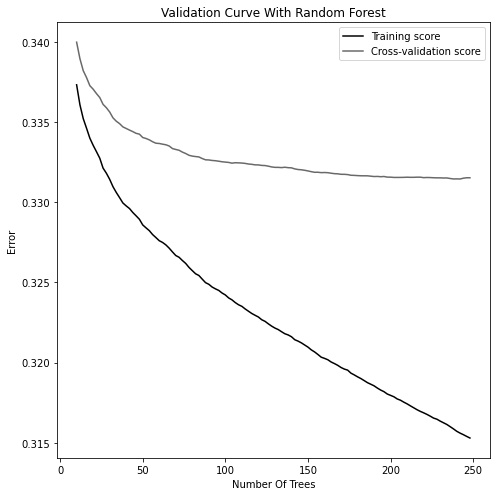

In [81]:
from sklearn.model_selection import validation_curve
param_range = np.arange(10, 250, 2)

# train_scores, test_scores = validation_curve(xg_reg_base,
#                                   X, y, param_name="n_estimators", param_range=param_range,
#                                   cv=cv_shuffle, scoring="neg_root_mean_squared_error", n_jobs=-1)
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
train_scores = [ ]
test_scores = [ ]
for i in param_range:
    xg_reg = xgb.XGBRegressor(**study1.best_params,

        n_estimators = i

)
    xg_reg.fit(X_train,y_train)
    train_scores.append(np.sqrt(mean_squared_error(y_train,xg_reg.predict(X_train))))
    test_scores.append(np.sqrt(mean_squared_error(y_valid,xg_reg.predict(X_valid))))

import matplotlib.pyplot as plt

plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_scores, label="Training score", color="black")
plt.plot(param_range, test_scores, label="Cross-validation score", color="dimgrey")

# plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
# plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
 
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Error")
plt.tight_layout()
plt.legend(loc="best")
plt.show()


In [82]:
model_tuned = XGBRegressor(**study1.best_params, n_estimators=150)

Creating the pipeline

In [83]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model_tuned)
                     ])

In [84]:
my_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  QuantileTransformer(n_quantiles=100,
                                                                      output_distribution='normal'),
                                                  ['cont0', 'cont1', 'cont2',
                                                   'cont3', 'cont4', 'cont5',
                                                   'cont6', 'cont7', 'cont8',
                                                   'cont9', 'cont10']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cat0', 'cat1', 'cat2',
                                                   'cat3', 'cat4', 'cat5',
                                                   'cat6', 'cat7', 'cat8',
                                            

In [85]:
prediction = my_pipeline.predict(test)
prediction

array([0.12232693, 0.47010115, 0.06467848, ..., 0.68102574, 0.09438159,
       0.32114324], dtype=float32)

Creating submission file

In [75]:
submission = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv')
submission['target'] = prediction
submission = submission.set_index('id')
submission
submission.to_csv('xgboostreg_optuna3.csv')